# Imports

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from percolation import read_percolation_data
from sklearn.model_selection import train_test_split
import sys

# Loading and preprocessing the data

In [18]:
L = 256
pc = 0.59274
#p_arr = np.round(np.arange(0, 1.0, 0.01), 4)
p_arr = np.round(np.array([0.57, 0.58, 0.61, 0.62]), 4)
p_arr = np.append(p_arr, pc)

In [19]:
X, y = read_percolation_data(L, p_arr, pc, max_configs_per_p=2000)

In [20]:
print(X.shape, y.shape)

(10000, 256, 256, 1) (10000,)


In [21]:
N = X.shape[0]
L = X.shape[1] 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [23]:
print('X.shape:', X.shape, ', y.shape:', y.shape)
print('X_train.shape:', X_train.shape, ', y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape, ', y_test.shape:', y_test.shape)

X.shape: (10000, 256, 256, 1) , y.shape: (10000,)
X_train.shape: (8000, 256, 256, 1) , y_train.shape: (8000,)
X_test.shape: (2000, 256, 256, 1) , y_test.shape: (2000,)


In [24]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 5


# Definition of the network and training for classification

In [25]:
def CNN_net(L, K):
    # input layer
    i = Input(shape=(L,L,1))

    # Convolution block
    x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # Classification block
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(K, activation='softmax')(x)

    model = Model(i, x)
    return model

In [26]:
model_phase = CNN_net(L, K)

In [27]:
# Compiling the model

# Inverse time decaying learning rate
# initial_learning_rate / (1 + decay_rate * floor(step / decay_step))
initial_learning_rate = 0.01
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_phase.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
# data augmentation, we allow for rotations of the image.
# At critical temperature, one could also allow for scalings?
#batch_size = 20
#data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True)
#train_generator = data_generator.flow(X_train, y_train, batch_size)
#steps_per_epochs = X_train.shape[0] // batch_size

In [29]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')

#initial_learning_rate = 0.01
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.001)

In [30]:
#opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
#model_phase.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
# training the model
#r_phase = model_phase.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch=steps_per_epochs, epochs=50)
r_phase = model_phase.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stop])

Epoch 1/20
250/250 [==============================] - 2030s 8s/step - loss: 61.6282 - accuracy: 0.5969 - val_loss: 16596.0840 - val_accuracy: 0.2000
Epoch 2/20
250/250 [==============================] - 1710s 7s/step - loss: 1.0160 - accuracy: 0.6587 - val_loss: 8805.0439 - val_accuracy: 0.2000
Epoch 3/20
250/250 [==============================] - 1390s 6s/step - loss: 0.9149 - accuracy: 0.6998 - val_loss: 44.6799 - val_accuracy: 0.2000
Epoch 4/20
250/250 [==============================] - 1334s 5s/step - loss: 0.8363 - accuracy: 0.7200 - val_loss: 0.8287 - val_accuracy: 0.8005
Epoch 5/20
250/250 [==============================] - 1338s 5s/step - loss: 0.8317 - accuracy: 0.7309 - val_loss: 0.5182 - val_accuracy: 0.8755
Epoch 6/20
250/250 [==============================] - 1332s 5s/step - loss: 0.7834 - accuracy: 0.7464 - val_loss: 0.4511 - val_accuracy: 0.8920
Epoch 7/20
250/250 [==============================] - 1334s 5s/step - loss: 0.7724 - accuracy: 0.7496 - val_loss: 0.4691 - val_

In [32]:
# We save the model
model_phase.save('../../criticality_trained_models/cnn_percolation([0.57, 0.58, 0.61, 0.62, pc], L=256).h5')

In [33]:
# to load it:
#model_phase = tf.keras.models.load_model('~/ml/research/criticality_trained_models/cnn_ising_phase.h5')

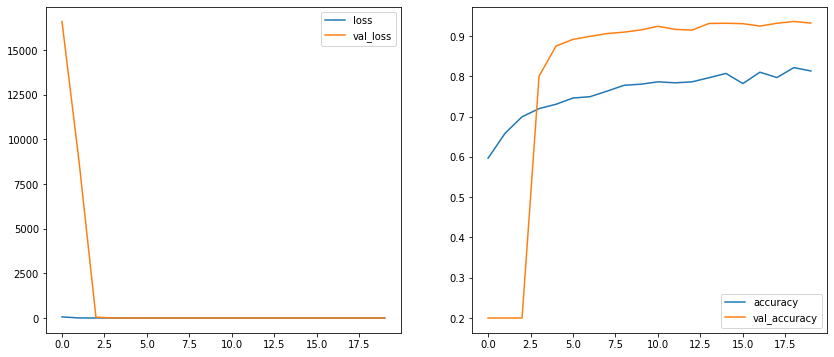

In [34]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(r_phase.history['loss'], label='loss')
plt.plot(r_phase.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(r_phase.history['accuracy'], label='accuracy')
plt.plot(r_phase.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [35]:
# Let us plot the confusion matrix
p_test = model_phase.predict(X_test).argmax(axis=1)
conf_matrix = confusion_matrix(y_test, p_test)

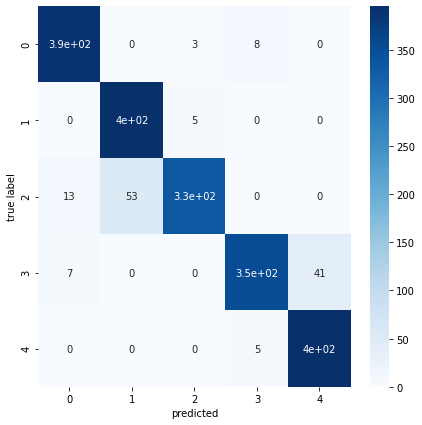

In [36]:
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, cmap='Blues', annot=True)
plt.xlabel('predicted')
plt.ylabel('true label')
plt.savefig('./saved_images/cnn_percolation([0.57, 0.58, 0.61, 0.62, pc], L=256).jpg')
plt.show()